In [1]:
#Let's go ahead and start with some imports
import pandas as pd
from pandas import Series,DataFrame
import numpy

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from yahoo
import pandas_datareader.data as web

# For time stamps
from datetime import datetime

# For division
from __future__ import division

/home/rafael/prj/data_analysis/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
GOOG2015 = web.DataReader('GOOG', 'yahoo', datetime(2015, 1, 1), datetime(2016, 1, 1))
GOOG2016 = web.DataReader('GOOG', 'yahoo', datetime(2016, 1, 1), datetime(2017, 1, 1))

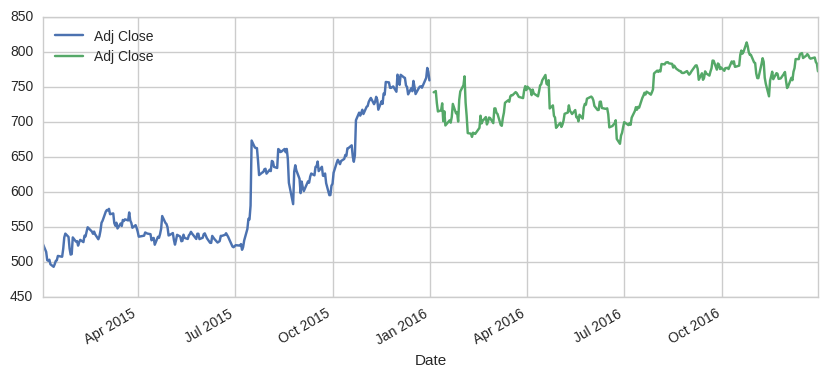

In [4]:
GOOG2015['Adj Close'].plot(legend=True, figsize=(10, 4))
GOOG2016['Adj Close'].plot(legend=True, figsize=(10, 4))

In [6]:
GOOG2015['Adj Close'].head()

Date
2015-01-02    524.812404
2015-01-05    513.872306
2015-01-06    501.962262
2015-01-07    501.102268
2015-01-08    502.682285
Name: Adj Close, dtype: float64

In [10]:
GOOG2015['returns'] = GOOG2015['Adj Close'].pct_change()
GOOG2016['returns'] = GOOG2016['Adj Close'].pct_change()

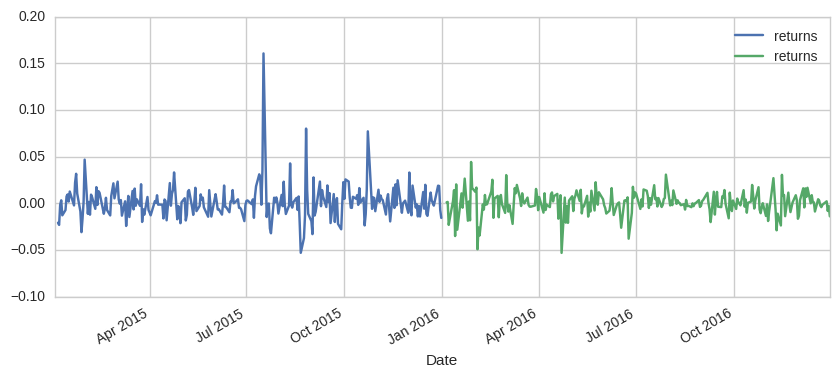

In [11]:
GOOG2015['returns'].plot(legend=True, figsize=(10, 4))
GOOG2016['returns'].plot(legend=True, figsize=(10, 4))

In [19]:
# Quantile Analysis
quantiles = GOOG2015['returns'].quantile([0.05, 0.01, 0.001])
quantiles

0.050   -0.021261
0.010   -0.032627
0.001   -0.049164
Name: returns, dtype: float64

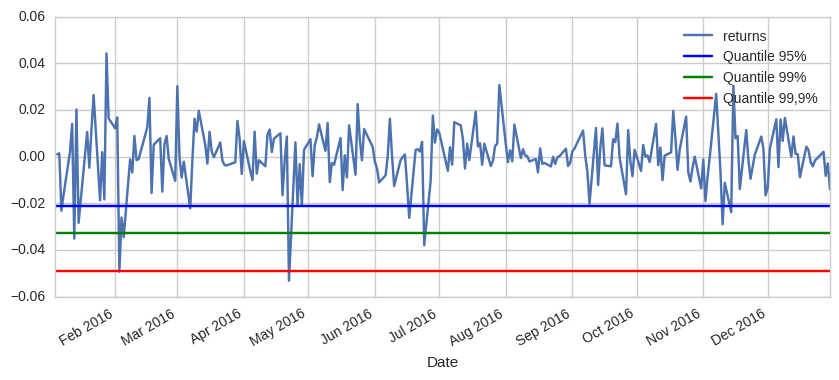

In [49]:
GOOG2016['returns'].plot(legend=True, figsize=(10, 4))
plt.axhline(y=quantiles[0.05], color='b').set_label('Quantile 95%')
plt.axhline(y=quantiles[0.01], color='g').set_label('Quantile 99%')
plt.axhline(y=quantiles[0.001], color='r').set_label('Quantile 99,9%')
plt.legend()

In [50]:
# Monte Carlo Analysis

In [68]:
def stock_monte_carlo(start_price,days,dt,mu,sigma):
    ''' This function takes in starting stock price, days of simulation,mu,sigma, and returns simulated price array'''
    
    # Define a price array
    price = numpy.zeros(days)
    price[0] = start_price
    # Schok and Drift
    shock = numpy.zeros(days)
    drift = numpy.zeros(days)
    
    # Run price array for number of days
    for x in xrange(1,days):
        
        # Calculate Schock
        shock[x] = numpy.random.normal(loc=mu * dt, scale=sigma * numpy.sqrt(dt))
        # Calculate Drift
        drift[x] = mu * dt
        # Calculate Price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

In [94]:
GOOG2016.head()

,Open,High,Low,Close,Volume,Adj Close,returns
Date,,,,,,,
2016-01-04,743.000000,744.059998,731.257996,741.840027,3272800,741.840027,NaN
2016-01-05,746.450012,752.000000,738.640015,742.580017,1950700,742.580017,0.000998
2016-01-06,730.000000,747.179993,728.919983,743.619995,1947000,743.619995,0.001400
2016-01-07,730.309998,738.500000,719.059998,726.390015,2963700,726.390015,-0.023170
2016-01-08,731.450012,733.229980,713.000000,714.469971,2450900,714.469971,-0.016410


In [95]:
def run_simulations(runs):
    simulations = numpy.zeros(runs)
    
    start_price = 743
    days = 365
    dt = 1/days
    mu = returns.mean()
    sigma = returns.std()

    for run in xrange(runs):
        simulations[run] = stock_monte_carlo(start_price, days, dt, mu, sigma)[days-1]
    return simulations

def multicore_simulations(runs, dview):
    with dview.sync_imports():
        import numpy
    
    sims = dview.map_sync(run_simulations, [int(runs/len(dview))]*len(dview))
    return sims


In [96]:
import ipyparallel
clients = ipyparallel.Client()
dview = clients[:]

dview['returns'] = GOOG2015['returns']
dview['stock_monte_carlo'] = stock_monte_carlo

In [97]:
%time simulations = multicore_simulations(1000000, dview)

importing numpy on engine(s)
CPU times: user 60 ms, sys: 20 ms, total: 80 ms
Wall time: 6min 22s


In [98]:
simulations = [item for sublist in simulations for item in sublist]

In [102]:
quantile2016 = numpy.percentile(simulations, 0.1)
quantile2016

703.58304682409937

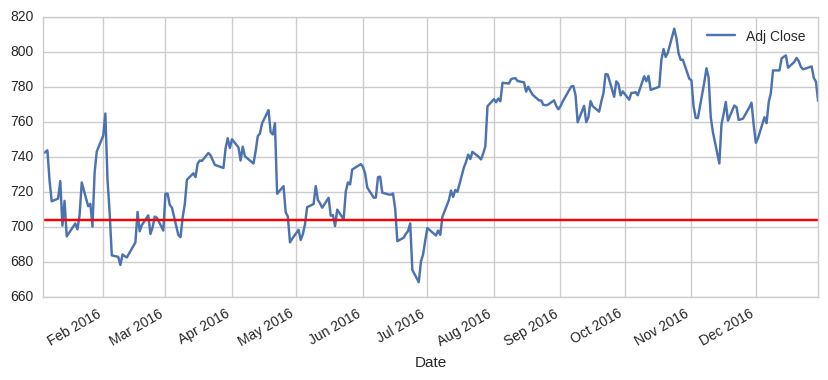

In [103]:
GOOG2016['Adj Close'].plot(legend=True, figsize=(10,4))
plt.axhline(y=quantile2016, color='r').set_label('Quantile 99.9%')